# Speech separation CNN model

In this notebook we implemented an U-net shaped convolutional network loosely based on Yu et al 2017.

### Basic setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The shape parameters of the input:

In [0]:
S = 2   # Number of speakers
F = 257 # Number of STFT frequency bins
T = 431 # Number of STFT time bins
SFT=S*F*T

Using our previously generated dataset, which is in HDF5 format:

In [0]:
h5Path = "/content/gdrive/My Drive/Nagy házi/audiobooks/train_data/data2.hdf5"
model_weights_path = "/content/gdrive/My Drive/Nagy házi/unet_softmax.hdf5"
training_log_path = "/content/gdrive/My Drive/Nagy házi/unet_softmax.csv"

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.utils import HDF5Matrix

In [0]:
x_train = HDF5Matrix(datapath=h5Path,
                     dataset='trainInput')

y_train = HDF5Matrix(datapath=h5Path,
                     dataset='trainOutput')

x_valid = HDF5Matrix(datapath=h5Path,
                     dataset='validInput')

y_valid = HDF5Matrix(datapath=h5Path,
                     dataset='validOutput')

Due to a [bug](https://github.com/tensorflow/tensorflow/issues/30993) in Tensorflow, the validation data cannot be in HDF5 format:

In [0]:
import numpy as np
x_valid_arr = np.array(x_valid)
y_valid_arr = np.array(y_valid)

The input of the network is the STFT magnitude of the mixed speech.

In [0]:
input_shape = (F,T,1)

The output are two masks that are used to isolate the magnitude spectra corresponding to the two speakers.

In [0]:
output_shape = (F,T,2)

## Model

Now we define the model:

In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Lambda, BatchNormalization
from tensorflow.keras.layers import concatenate, Add, Conv2DTranspose
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np
from math import floor

A softmax activation was used in Yu et al 2017 on the last axis of the output:

In [0]:
def softMaxAxisLast(x):
    return softmax(x,axis=-1)

A concolutional block of the U-net structure:

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

A U-net three layers deep:

In [0]:
def get_unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = ZeroPadding2D(((0,0),(0,1)))(u6)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = ZeroPadding2D(((0,0),(0,1)))(u7)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = ZeroPadding2D(((0,0),(0,1)))(u8)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = ZeroPadding2D(((0,1),(0,1)))(u9)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='relu') (c9)
    outputs = Activation(softMaxAxisLast)(outputs)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_stft = Input(input_shape, name = 'mixed_stft')
model = get_unet(input_stft,
                 n_filters = 16,
                 batchnorm=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mixed_stft (InputLayer)         [(None, 257, 431, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 257, 431, 16) 160         mixed_stft[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 257, 431, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 257, 431, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

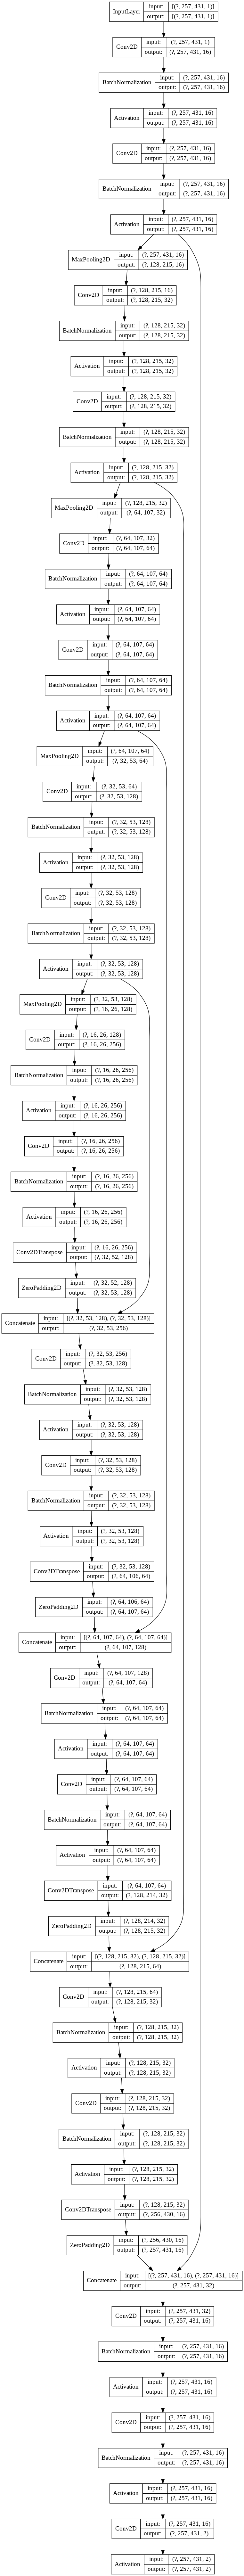

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_combined.png', show_layer_names=False, show_shapes=True)

## Loss

The main idea of Yu et al. 2017 was permutation invariant training. After the masks output by the network are applied to the STFT amplitude of the mixed signal, the speaker assignment is chosen from the permutation yielding the least error.

For this we needed to define a custom loss function, which is implemented for Keras in the `pitLossWrapper` function.

In [0]:
def yuxuanError(estXsAbs, XsAbs):
  # Error from the first speaker
  err0 = K.sum(K.sum(K.abs(estXsAbs[0] - XsAbs[...,0])**2, axis=-1), axis=-1)
  # Error from the second speaker
  err1 = K.sum(K.sum(K.abs(estXsAbs[1] - XsAbs[...,1])**2, axis=-1), axis=-1)
  err = err0 + err1
  return err/SFT

import itertools
def pitLoss(estXsAbs, XsAbs):
  # Calculate the error for all permutations, and select the one with the
  # least error: this is the permutation invariant part of the loss.
  return K.min([yuxuanError(list(p), XsAbs) for p in itertools.permutations(estXsAbs)], axis=0)

def pitLossWrapper(y_true, y_pred):
  estMs = y_pred[...,:2]
  XsAbs = y_true[...,1:]
  Yabs = y_true[...,0]
  estXsAbs = [estMs[...,0] * Yabs, estMs[...,1] * Yabs]
  return pitLoss(estXsAbs, XsAbs)

## Training

We used the Adam optimizer.



In [0]:
model.compile(optimizer="adam",
              loss=pitLossWrapper)

Early stopping:

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=15,
                               verbose=1,
                               mode='auto')

checkpoint = ModelCheckpoint(model_weights_path,
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True)

logger = CSVLogger(training_log_path)

Fitting the model:

In [0]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_valid_arr,y_valid_arr),
          epochs=200,
          shuffle='batch',
          batch_size=32,
          callbacks=[early_stopping, checkpoint, logger],
          verbose=1)

Reload the early stopping weights and check the loss values:

In [0]:
model.load_weights(model_weights_path)

In [0]:
model.evaluate(x=x_train,
               y=y_train)

9112/9112 [==============================] - 227s 25ms/sample - loss: 0.0253


0.02525447048181447

In [0]:
model.evaluate(x=x_valid,
               y=y_valid)

506/506 [==============================] - 11s 22ms/sample - loss: 0.0553


0.055329200395717926

Check the training log:

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

train_log = pd.read_csv(training_log_path)

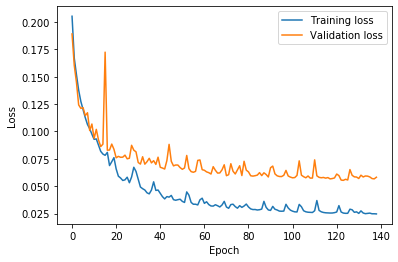

In [13]:
plt.plot(train_log['loss'])
plt.plot(train_log['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])